In [1]:
%%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

# seed_number_range = []
# for num in range(10):
#     for N_Cells_PF_events in [0]:#0,1,2]:
#         N_Cells_PF_OU = N_Cells_PF - N_Cells_PF_events     
#         if N_Cells_PF_events == 0: 
#             CS_val = 0
#             US_val = 0
#             seed_number_range.append(f'Event_{num}_OU_{N_Cells_PF_OU}_Stim_{N_Cells_PF_events}_CS_{CS_val}_US_{US_val}')
#             continue
#         for CS_val in range(5,10,2):
#             for US_val in range(5,20,5):
#                 seed_number_range.append(f'Event_{num}_OU_{N_Cells_PF_OU}_Stim_{N_Cells_PF_events}_CS_{CS_val}_US_{US_val}')        

                
seed_number_range = []     
for num in range(2,3):
    seed_number_range.append(f'Paper_all_and_eyeblink')#Paper_new_delays_{num}')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 4
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0]#,5,10,15,20,25,50,100,800,1000,1100,1200,1300,1400]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}


Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

WARNING    <timed exec>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 29.7 s, sys: 9.44 s, total: 39.1 s
Wall time: 47 s


# Figure 1 - B 

### PF Input

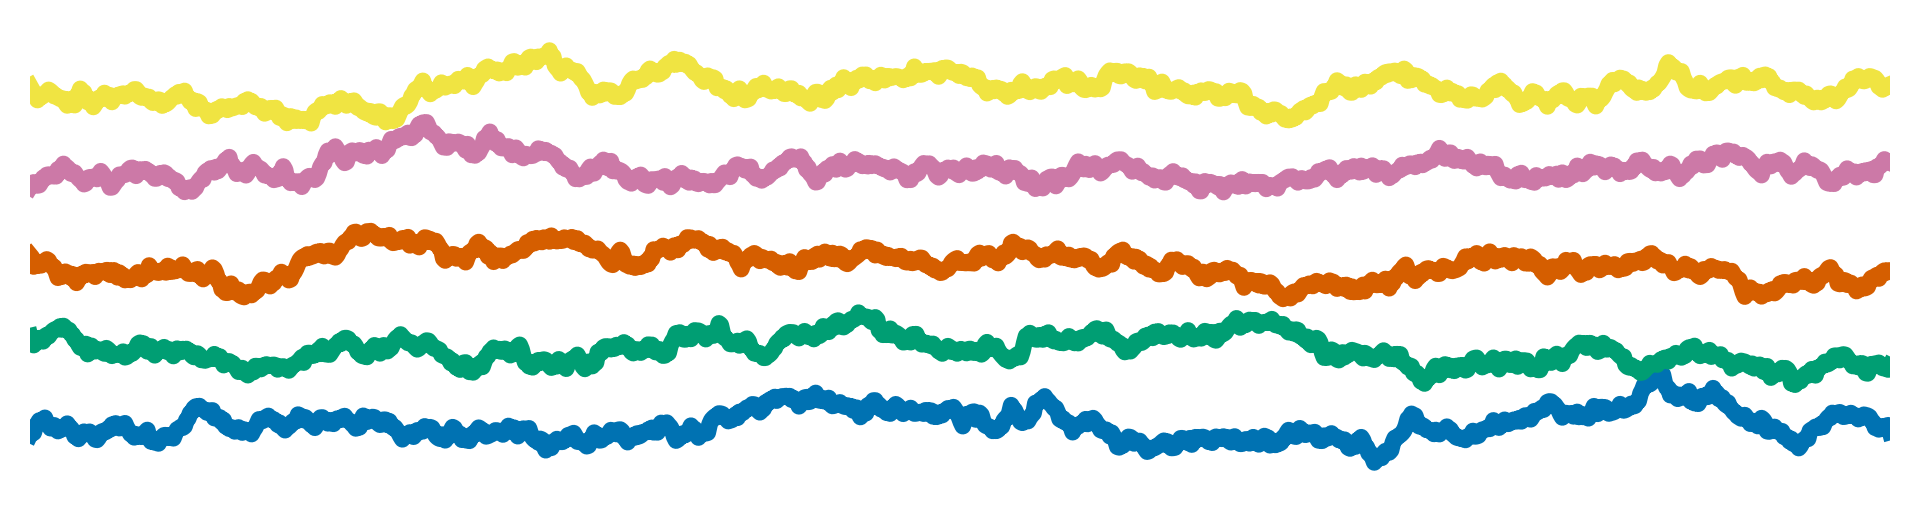

In [2]:
coupling = '_Coupled'
plasticity = 'no_Plasticity'
cmap = plt.get_cmap('Blues')

start = 12000
end = start+ 1000

fig_size= (8,2)


figure(figsize=fig_size, dpi= 300, facecolor='w', edgecolor='k')
for Noise_num in range(N_Cells_PF):
    Cell_response = output_load_run('Noise',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['I'][Noise_num][start:end]/nA
    plot(linspace(start/1000,end/1000,int((end-start))),Noise_num+Cell_response*amp,color=f'C{Noise_num}',label=f'PF Bunde {Noise_num+1}',lw=4)
# ylabel(f'Current [nA]', fontsize=20)
# xlabel('Time [s]', fontsize=20)
sns.despine(offset=10, trim=True)
plt.axis('off')
xlim([start/1000,end/1000])
plt.savefig('PF_input.svg')
# ylim([0, 3])

### Cell Membrane potential responses

(-100.0, 50.0)

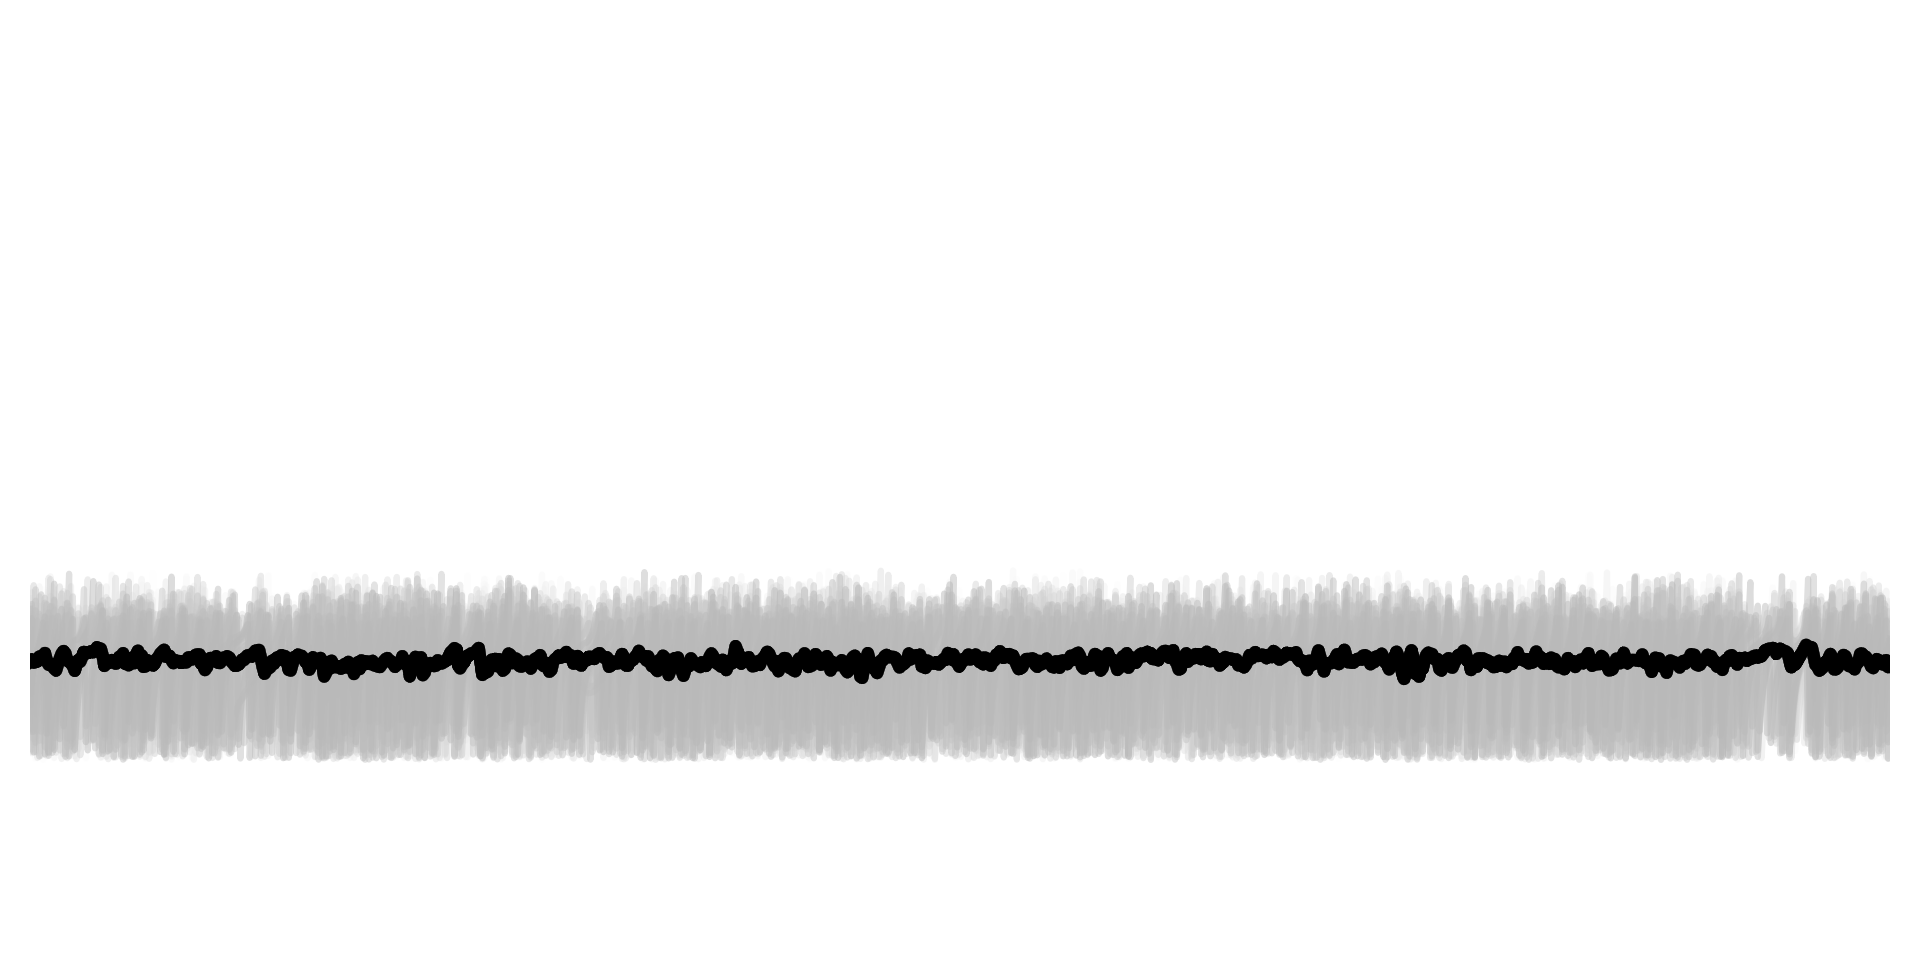

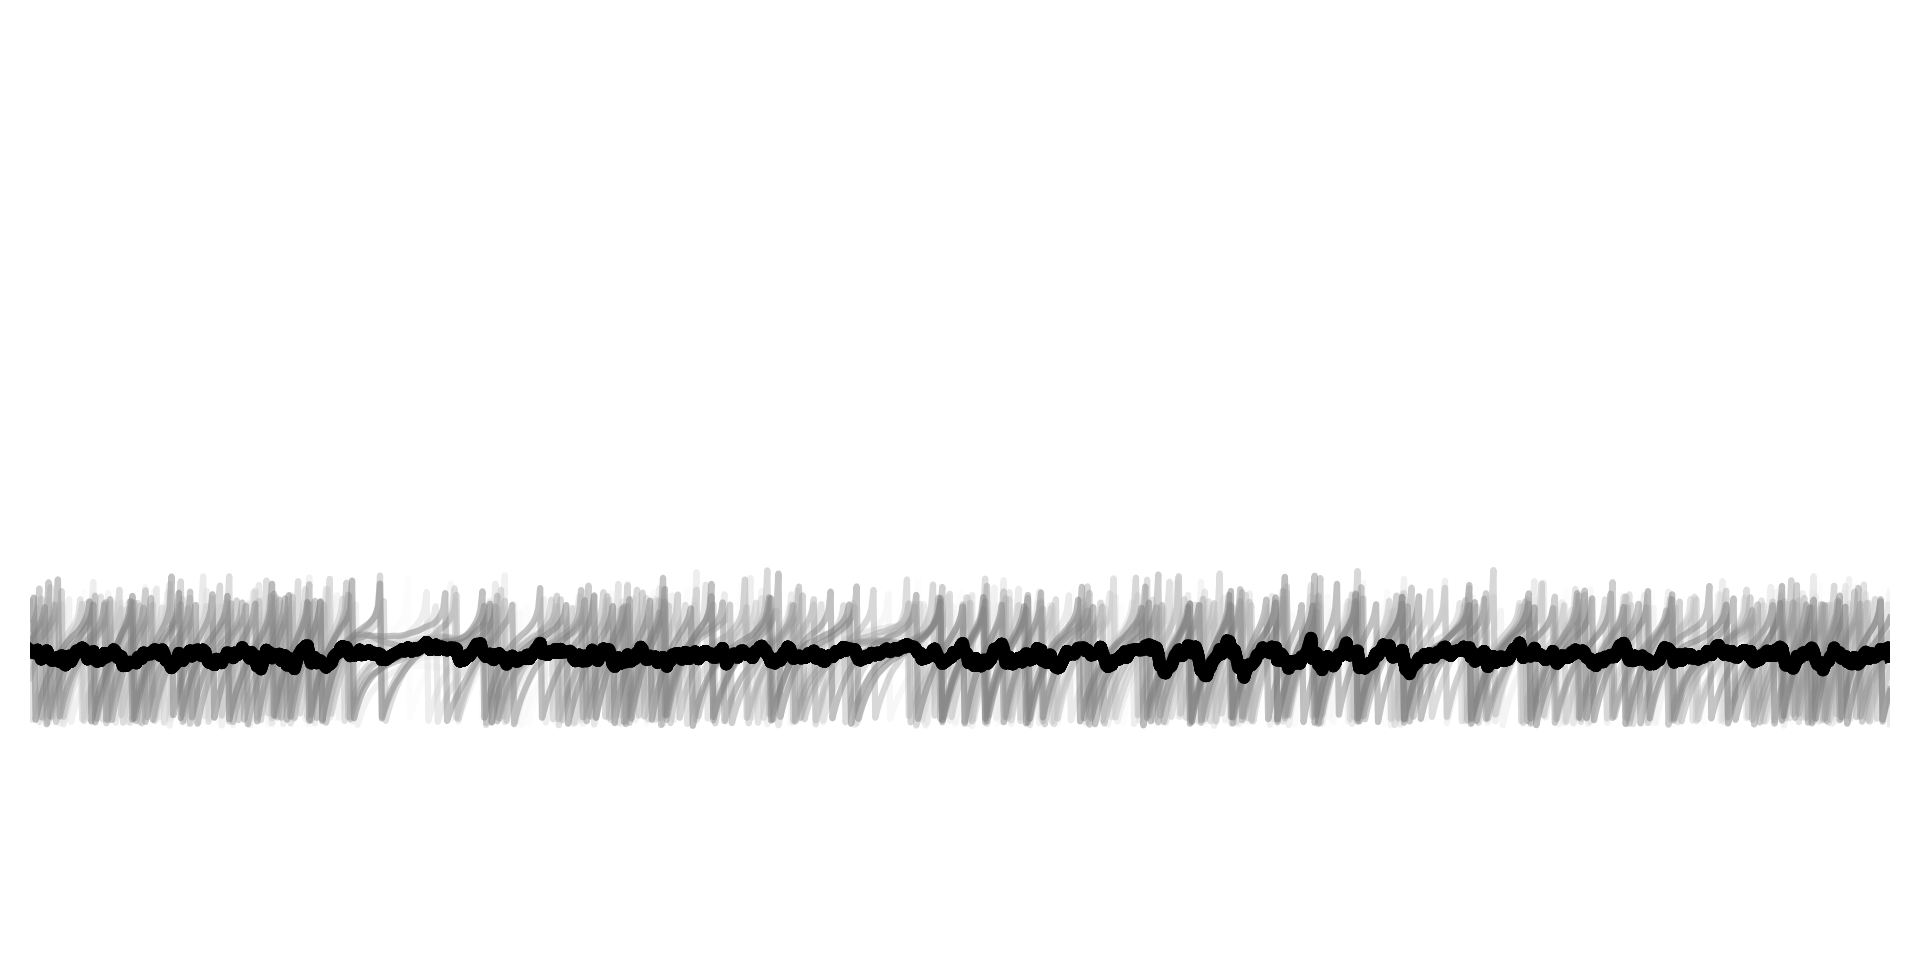

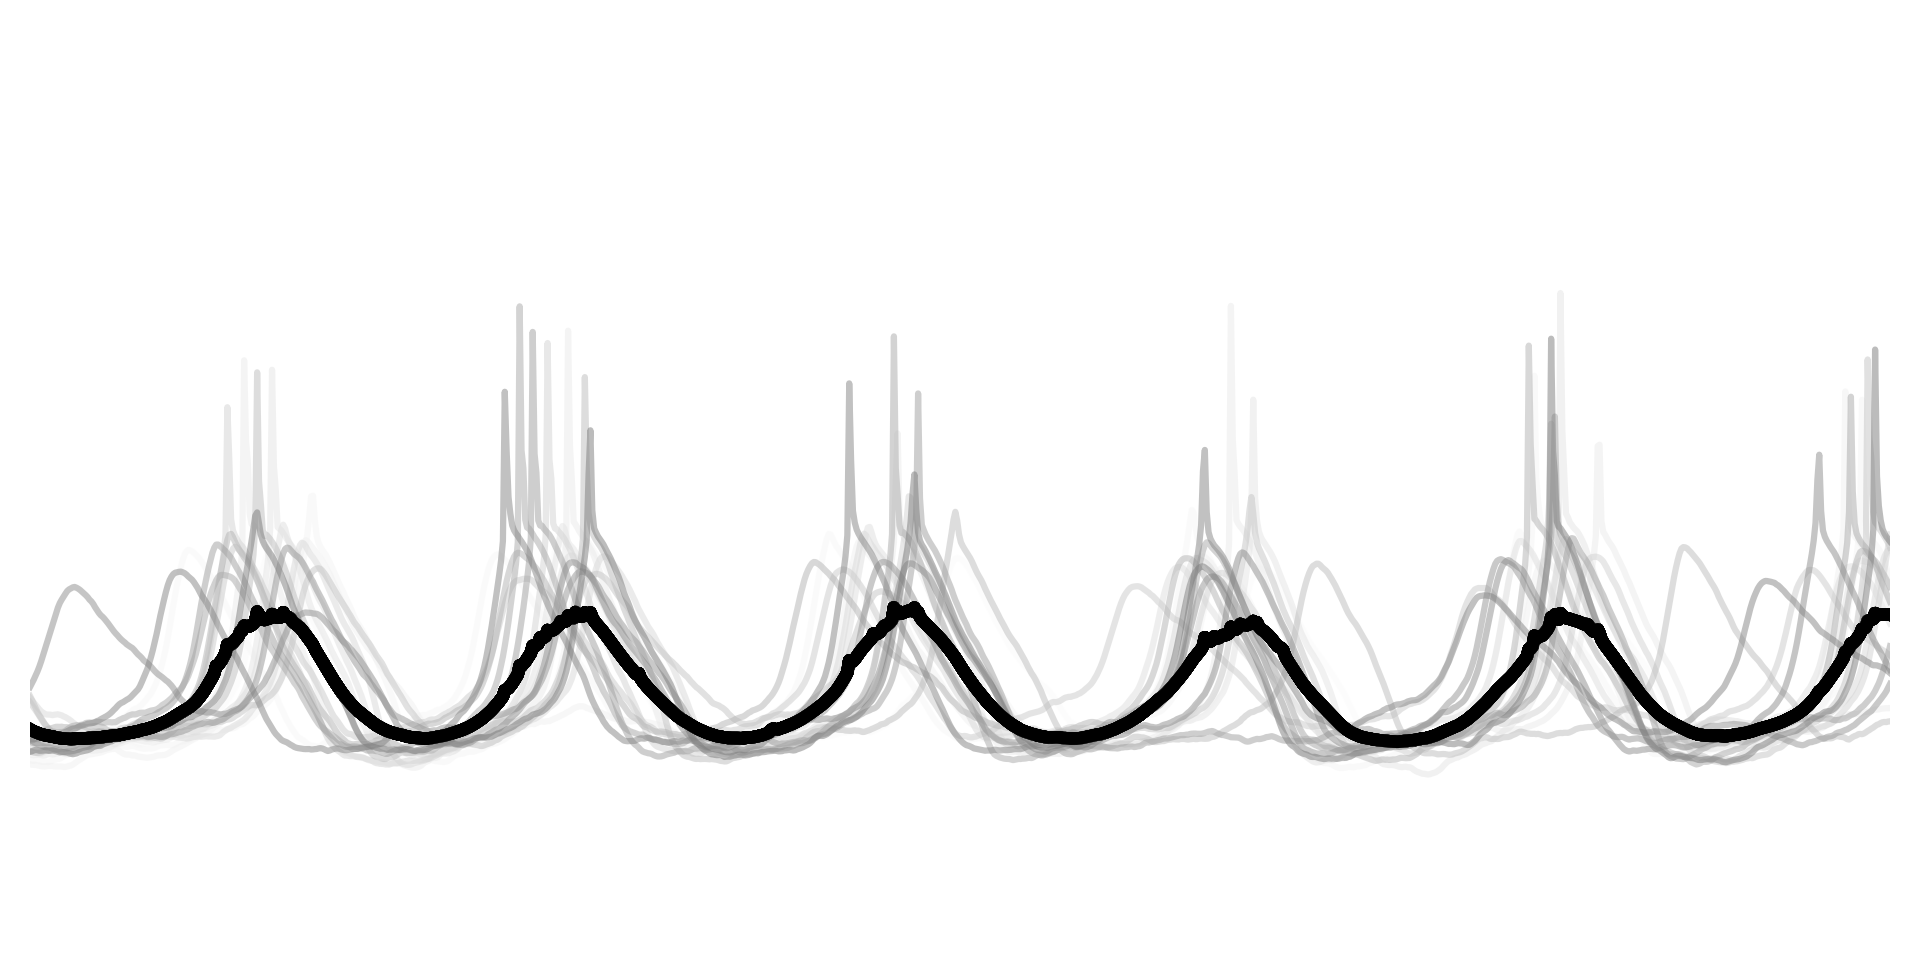

In [3]:
f0 = 0 
zebrin='negative'
coupling = '_Coupled'
plasticity = 'no_Plasticity'
cmap = plt.get_cmap('Greys')

start = 12000
end = start+ 1000

fig_size= (8,4)

fig= figure(figsize=fig_size, dpi= 300, facecolor='w', edgecolor='k')
mean_a = np.mean(output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['v'][:]/mV, axis=0)
x_axis = linspace(start/1000,end/1000,int((end-start)))
for pc_num in range(N_Cells_PC):
    plot(x_axis,output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['v'][pc_num][start:end]/mV,alpha=0.5, color=cmap(pc_num))
    plot(x_axis,mean_a[start:end],color='k',lw=3)
plt.axis('off')
xlim([start/1000,end/1000])
ylim([-100, 50])


fig= figure(figsize=fig_size, dpi= 300, facecolor='w', edgecolor='k')
mean_a = np.mean(output_load_run('DCN',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['v'][:]/mV, axis=0)
x_axis = linspace(start/1000,end/1000,int((end-start)))
for DCN_num in range(0,N_Cells_DCN,2):
    plot(x_axis,output_load_run('DCN',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['v'][DCN_num][start:end]/mV,alpha=0.5, color=cmap(4*DCN_num))
    plot(x_axis,mean_a[start:end],color='k',lw=3)
plt.axis('off')
xlim([start/1000,end/1000])
ylim([-100, 50])


fig= figure(figsize=fig_size, dpi= 300, facecolor='w', edgecolor='k')
mean_a = np.mean(output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['Vs'][:]/mV, axis=0)
x_axis = linspace(start/1000,end/1000,int((end-start)))
for IO_num in range(0,N_Cells_IO,2):
    plot(x_axis,output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['Vs'][IO_num][start:end]/mV,alpha=0.5, color=cmap(4*IO_num))
    plot(x_axis,mean_a[start:end],color='k',lw=3)
plt.axis('off')
xlim([start/1000,end/1000])
ylim([-100, 50])

### Cell rasters

(-1.0, 100.0)

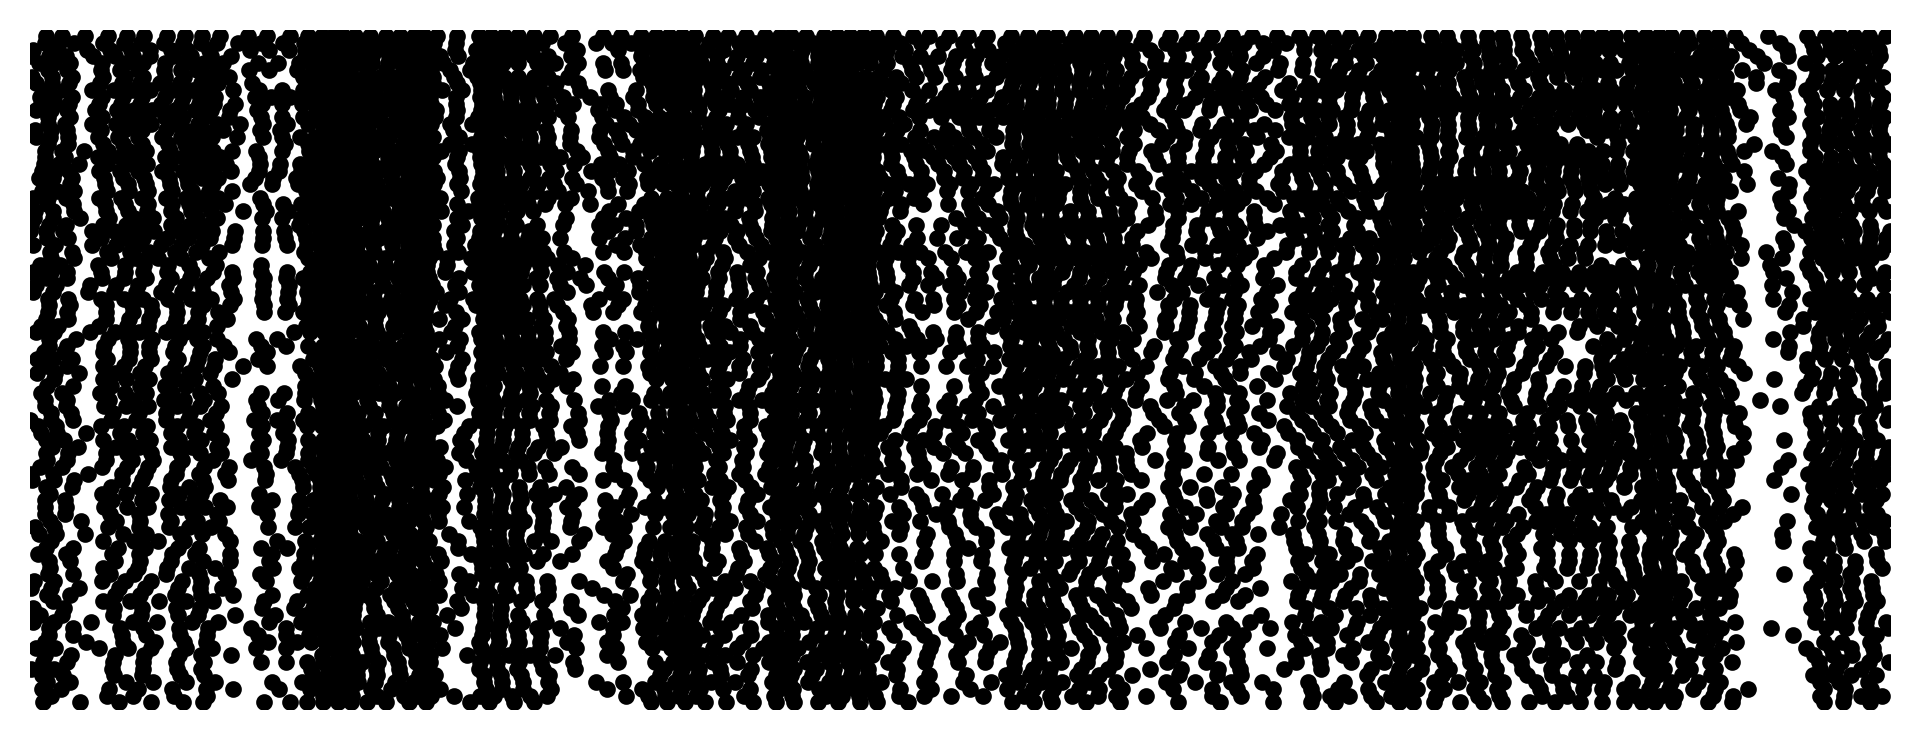

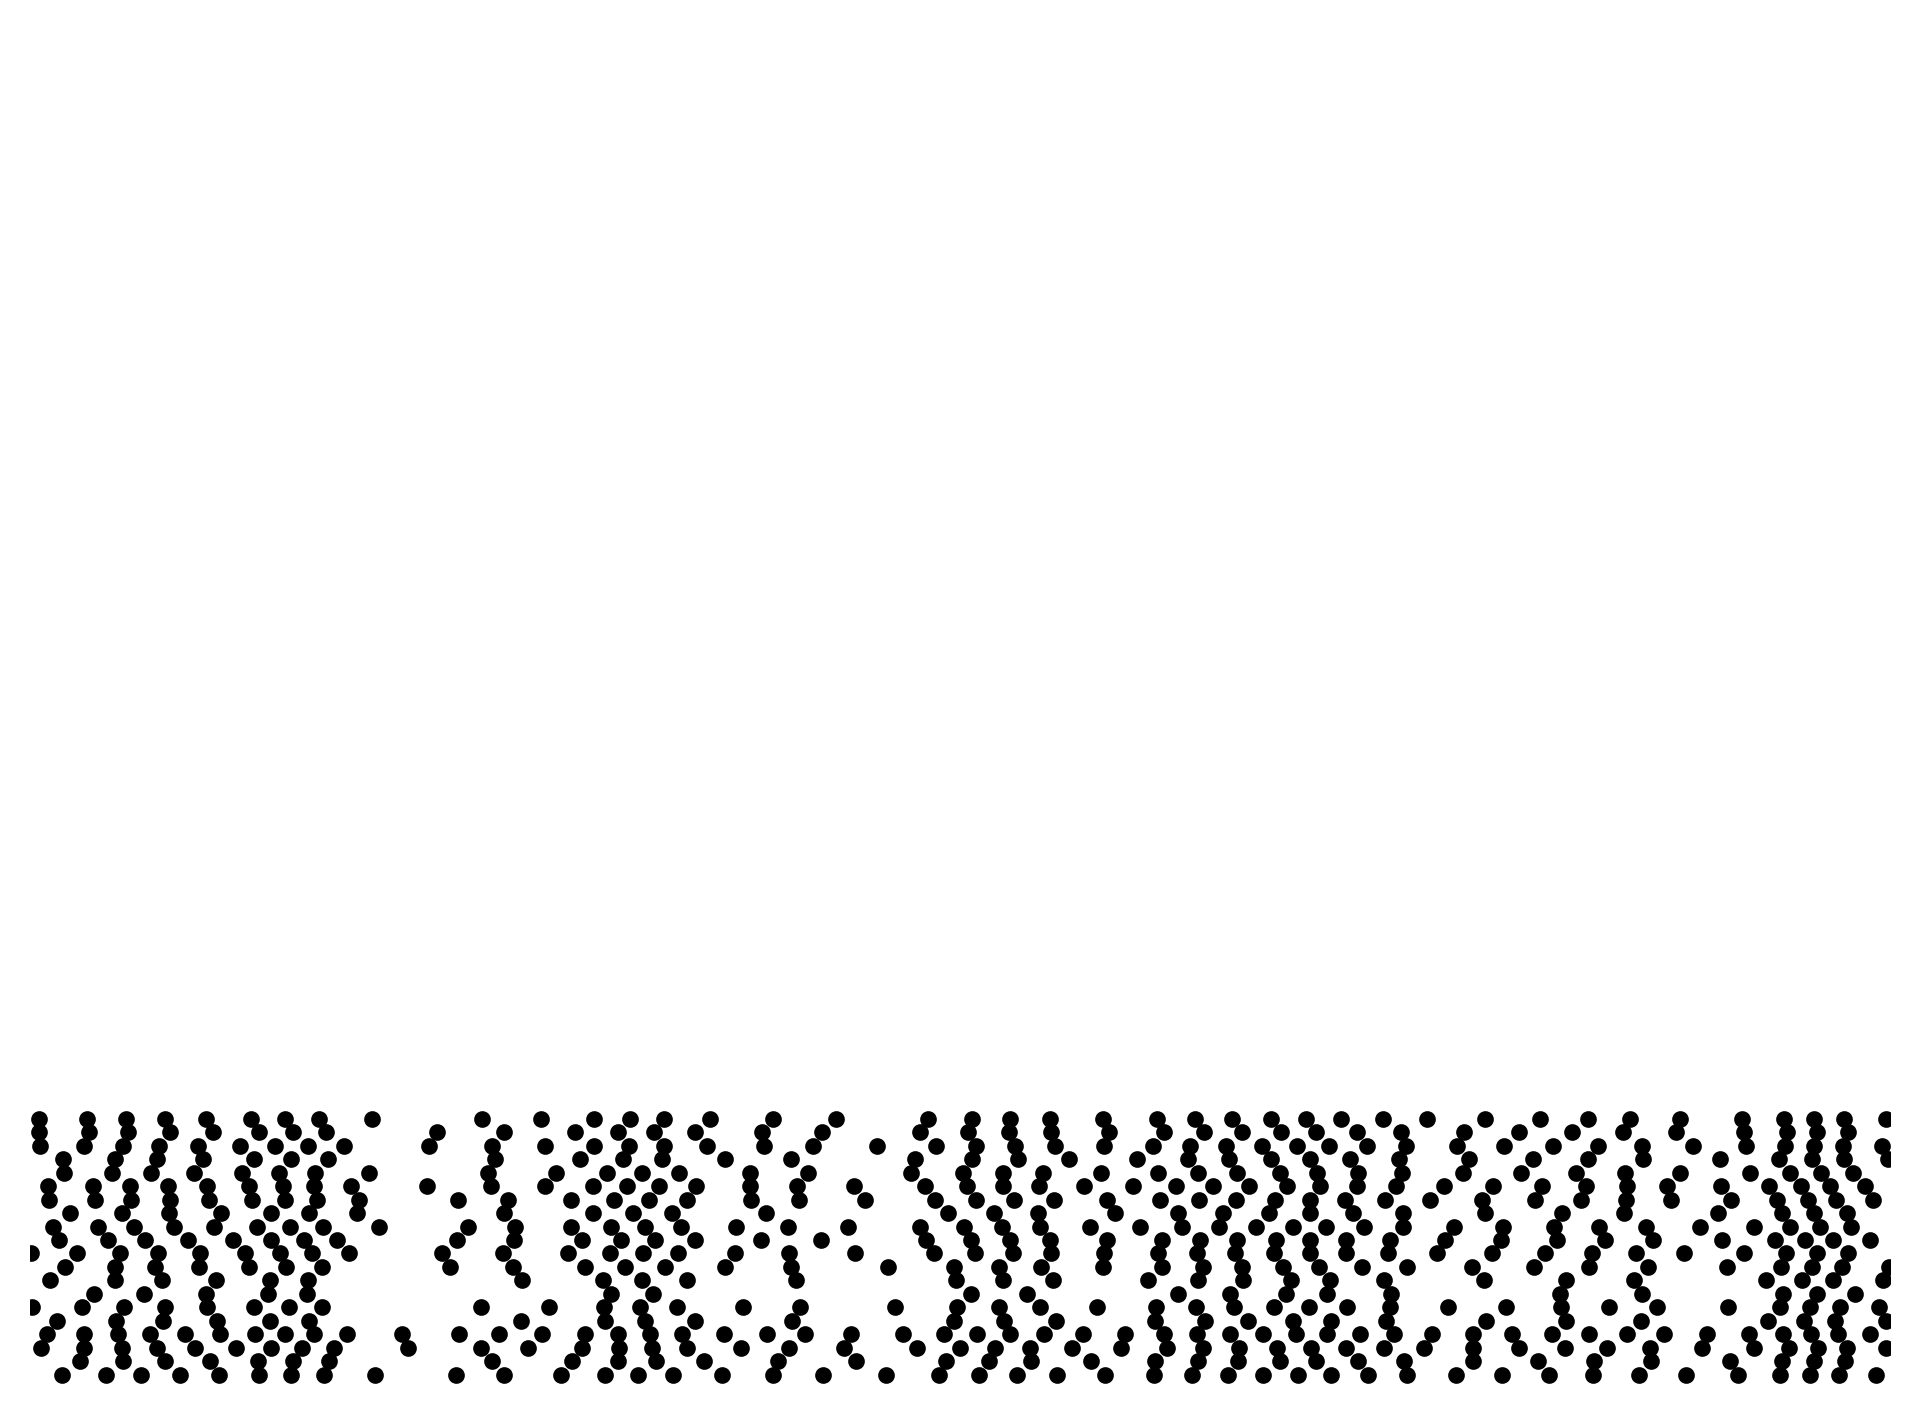

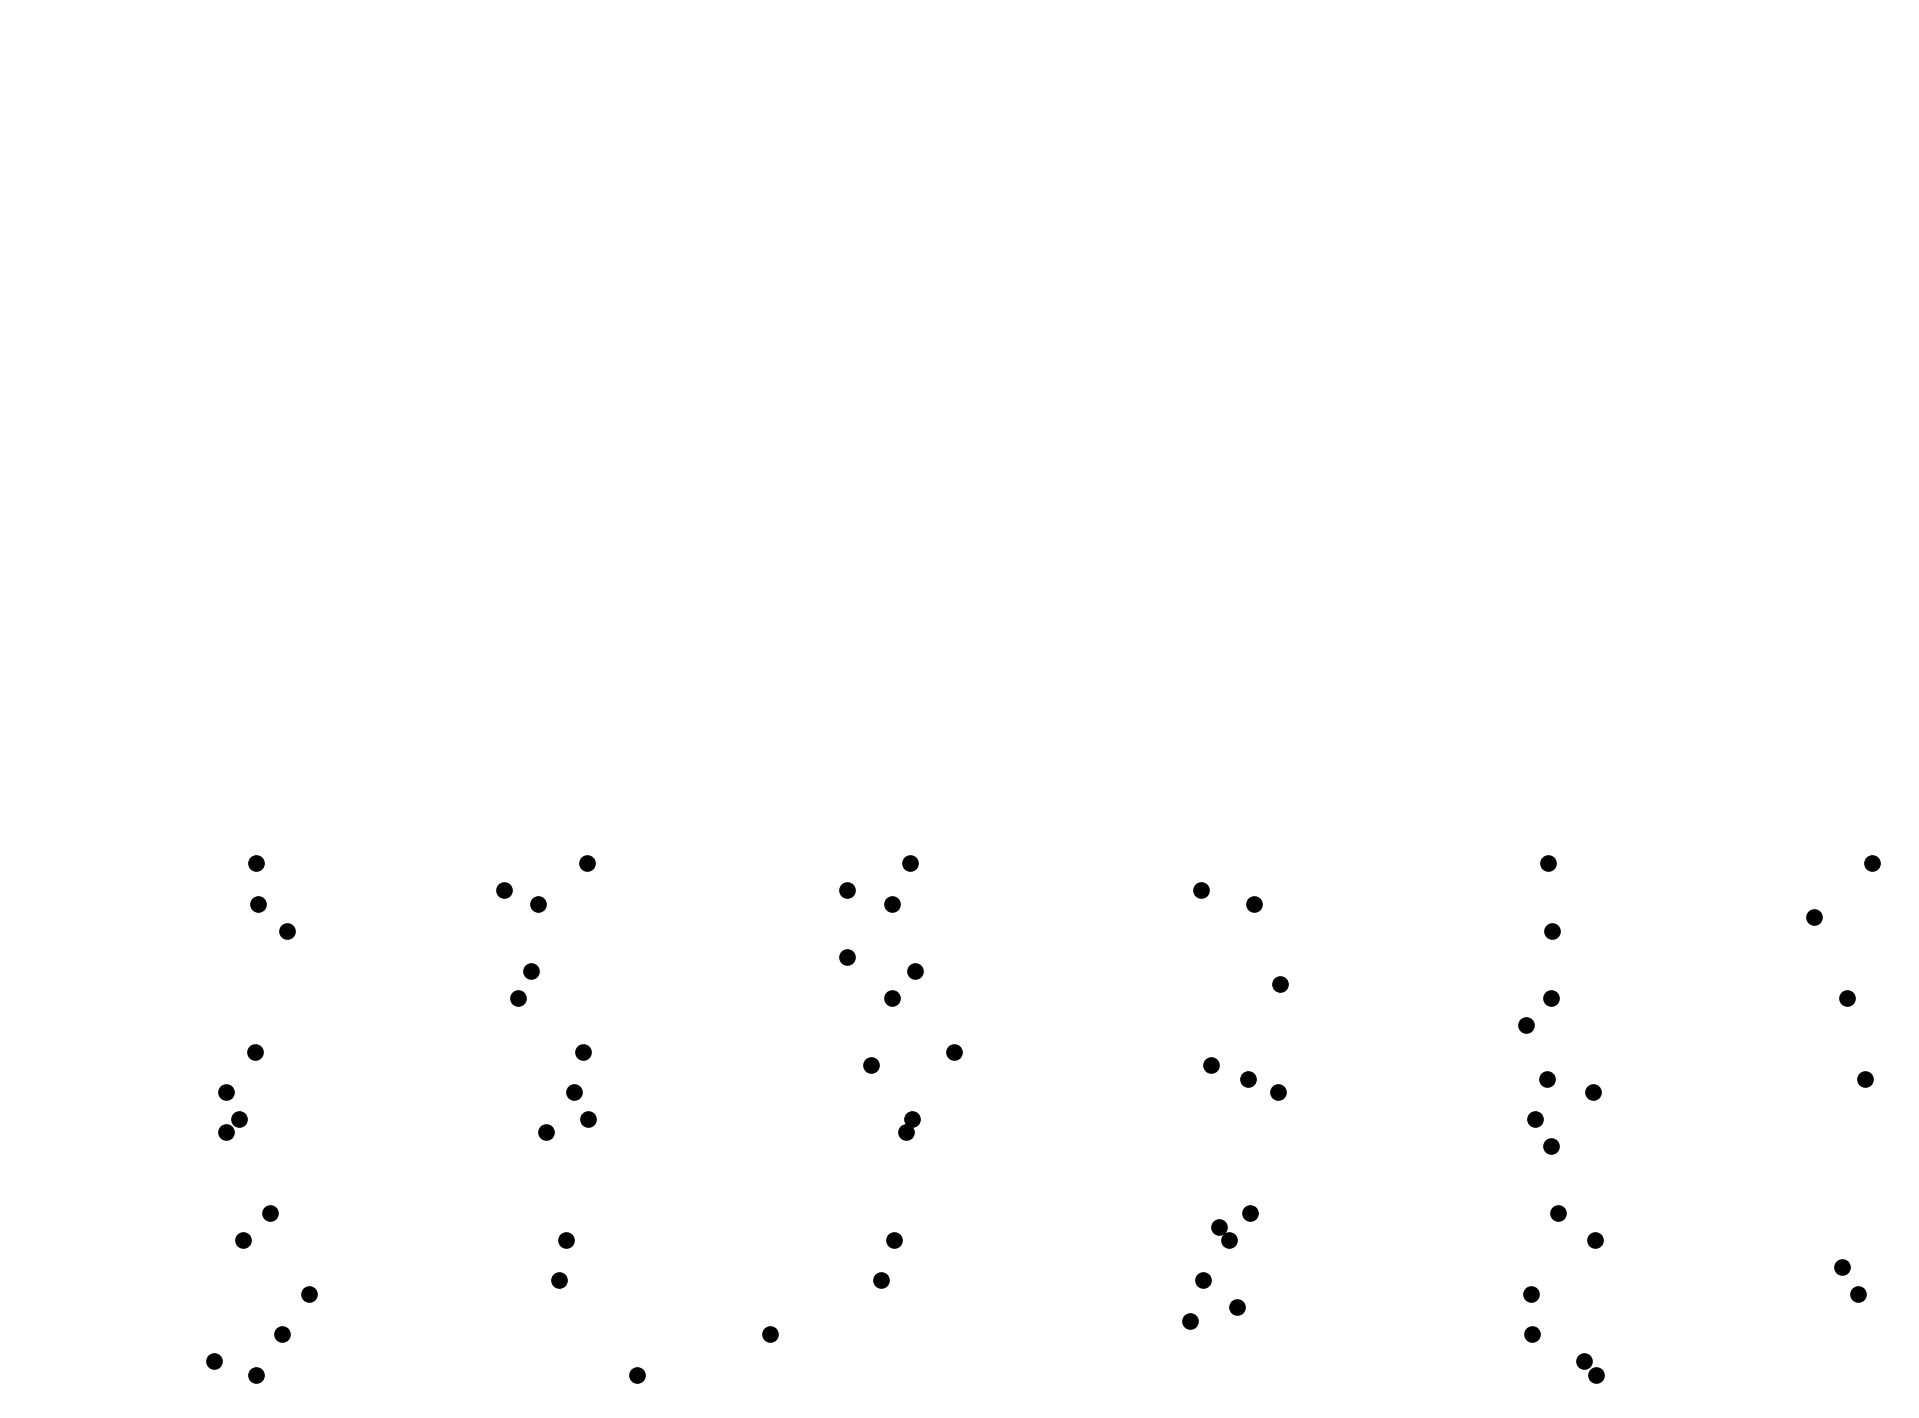

In [4]:
coupling = '_Coupled'
plasticity = 'no_Plasticity'
# cmap = plt.get_cmap('Blues')

start = 12000
end = start+ 1000

fig_size= (8,4)


fig= figure(figsize=(8,3), dpi= 300, facecolor='w', edgecolor='k')
for PC_num in range(N_Cells_PC):
    PC_Spike = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)[f'{PC_num}']
    PC_Spike = [x for x in PC_Spike if start/1000 <= x <= end/1000]
    plot(PC_Spike,[PC_num]*len(PC_Spike),'.',color='k',lw=1) 
plt.xlim([start/1000,end/1000])
plt.axis('off')
ylim([-1, N_Cells_PC])


fig= figure(figsize=(8,6), dpi= 300, facecolor='w', edgecolor='k')
for DCN_num in range(20):
    DCN_Spike = output_load_run('DCN_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)[f'{DCN_num}']
    DCN_Spike = [x for x in DCN_Spike if start/1000 <= x <= end/1000]
    plot(DCN_Spike,[DCN_num]*len(DCN_Spike),'.',color='k',lw=1) 
plt.xlim([start/1000,end/1000])
plt.axis('off')
ylim([-1, N_Cells_PC])


fig= figure(figsize=(8,6), dpi= 300, facecolor='w', edgecolor='k')
for IO_num in range(N_Cells_IO):
    IO_Spike = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)[f'{IO_num}']
    IO_Spike = [x for x in IO_Spike if start/1000 <= x <= end/1000]
    plot(IO_Spike,[IO_num]*len(IO_Spike),'.',color='k',lw=1) 
plt.xlim([start/1000,end/1000])
plt.axis('off')
ylim([-1, N_Cells_PC])

# Figure 1 - C

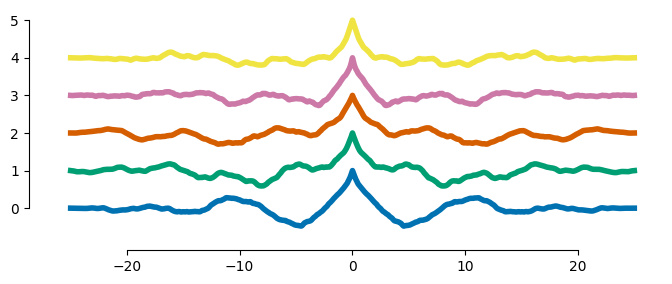

In [5]:
plasticity = 'no_Plasticity'
# for Noise_num in range(0,5):
#     figure(figsize=fig_size, dpi= 100, facecolor='w', edgecolor='k')
#     sig = output_load_run('Noise',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['I'][Noise_num][start:end]/nA
#     sig_noise = sig
#     a = (sig - np.mean(sig)) / (np.std(sig) * len(sig))
#     b = (sig_noise - np.mean(sig_noise)) / (np.std(sig_noise))
#     corr = signal.correlate(a, b)
#     lags = signal.correlation_lags(a.size, b.size, mode="full")
#     corr /= np.max(corr)
#     plt.plot(lags*dt/ms, corr,color=f'C{Noise_num}')
# #     plt.axis('off')
#     ylim([-1, 1])


figure(figsize=(8,3), dpi= 100, facecolor='w', edgecolor='k')
for Noise_num in range(N_Cells_PF):
    sig = output_load_run('Noise',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['I'][Noise_num][start:end]/nA
    sig_noise = sig
    a = (sig - np.mean(sig)) / (np.std(sig) * len(sig))
    b = (sig_noise - np.mean(sig_noise)) / (np.std(sig_noise))
    corr = signal.correlate(a, b)
    lags = signal.correlation_lags(a.size, b.size, mode="full")
    corr /= np.max(corr)
    plt.plot(lags*dt/ms, Noise_num+corr,color=f'C{Noise_num}',lw=4)
sns.despine(offset=10, trim=True)
# plt.axis('off')
# xlim([start/1000,end/1000])
# ylim([-1, 1])


# Figure 1 - D

CPU times: user 4.71 s, sys: 26.2 s, total: 30.9 s
Wall time: 38.6 s


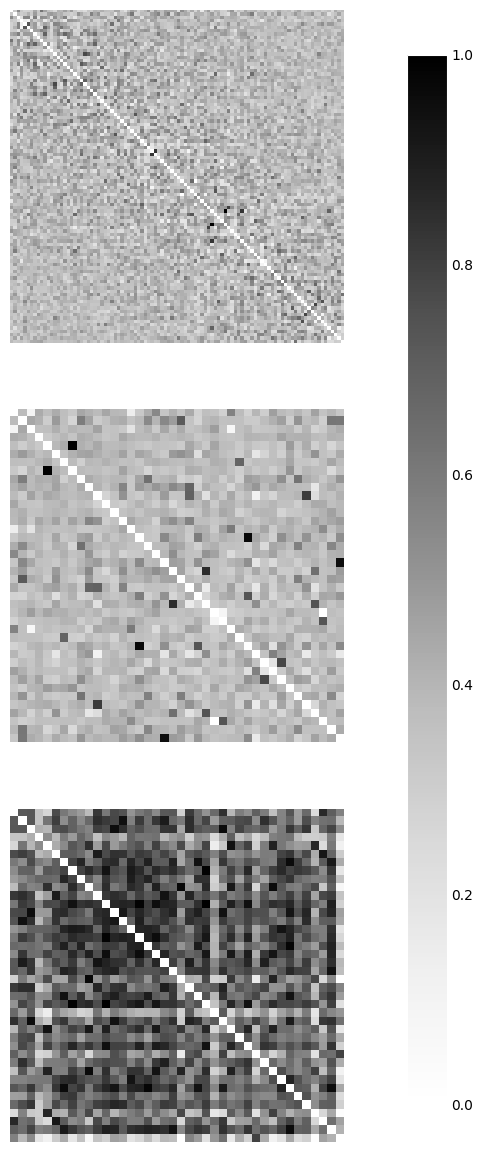

In [6]:
%%time

# f0=1000

start = 12000
end = start+ 1000
cmap = plt.get_cmap('Greys')


coupling = '_Coupled'
plasticity = 'no_Plasticity'


IO_num_range = IO_num_con
for IO_num in range(0,N_Cells_IO):
    if IO_num not in IO_num_range:
        IO_num_range =  np.append(IO_num_range, IO_num)
        
fig,axs = subplots(nrows=3, figsize=(8,15), dpi= 100, facecolor='w', edgecolor='k')
# suptitle(f'{plasticity}{coupling}')
v_PC = np.array([output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['v'][PC_num][int(start):int(end)]/mV for PC_num in range(N_Cells_PC)])
corr_matrix = np.corrcoef(v_PC)
np.fill_diagonal(corr_matrix, np.nan)
axs[0].imshow(corr_matrix,cmap=cmap)
axs[0].axis('off')

v_DCN = np.array([output_load_run('DCN',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['v'][DCN_num][int(start):int(end)]/mV for DCN_num in range(N_Cells_DCN)])
corr_matrix = np.corrcoef(v_DCN)
np.fill_diagonal(corr_matrix, np.nan)
axs[1].imshow(corr_matrix,cmap=cmap)
axs[1].axis("off")

v_IO = np.array([output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['Vs'][IO_num][int(start):int(end)]/mV for IO_num in range(N_Cells_IO)])
corr_matrix = np.corrcoef(v_IO)
np.fill_diagonal(corr_matrix, np.nan)
axs[2].imshow(corr_matrix,cmap=cmap)
axs[2].axis('off')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.75, 0.15, 0.05, 0.7])
cbar_ax.tick_params(size=0)
cb = colorbar(plt.cm.ScalarMappable(cmap=cmap),cax=cbar_ax)
cb.outline.set_color('white')
